In [25]:
from __future__ import annotations
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append('../module/')
import re
from data_handler import feature_engineering
from data_handler import get_econ_predictors
from data_handler import get_monthly_date_format, get_quarterly_date_format
from analysis import get_period_return
import itertools


# Data preparation for the FinRL environment

## Raw Data Feature

Panel data (long format)

Columns: date + OHLCV tic day (default) + indicators

Rows: all available stock data for each day


Hyper-parameters

In [1]:
TRAIN_START_DATE = '2002-08-01'
TRAIN_END_DATE = '2007-07-01'
TEST_START_DATE = '2007-07-01'
TEST_END_DATE = '2019-10-31'
TICKER_LIST = ['IVV', 'IEF']

In [21]:
data_freq = 'monthly'
START_DATE = '2002-08-01'
END_DATE = '2019-10-31'
date_freq_to_data_func_map = {'monthly': ('../../data/econ_predictors_monthly_2021_Amit_Goyal.csv',
                                        get_monthly_date_format), 
                            'quarterly': ('../../data/econ_predictors_quarterly_2021_Amit_Goyal.csv',
                                        get_quarterly_date_format)}
data_path, date_format_func = date_freq_to_data_func_map[data_freq]

data = pd.read_csv(data_path, index_col=0)
data.index = [date_format_func(str(x), {'format':'%Y%m'}) for x in data.index]
econ_data = data[START_DATE:END_DATE]

risk_free_rate = econ_data['Rfree']

In [37]:
risk_free_rate_2 = pd.read_csv('../../data/F-F_Research_Data_Factors_Monthly.csv', index_col=0)['RF']
risk_free_rate_2.index = [datetime.datetime.strptime(str(x), '%Y%m') for x in risk_free_rate_2.index]

<AxesSubplot:>

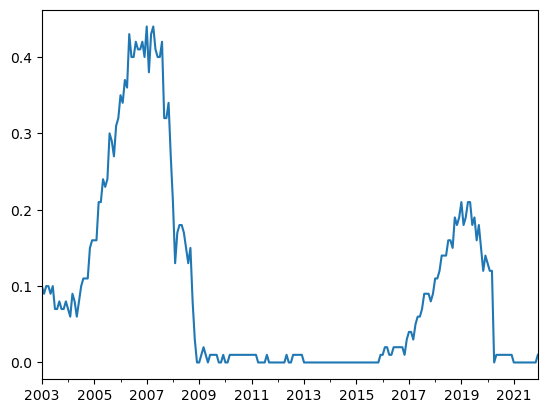

In [36]:
risk_free_rate_2.loc['2003':].plot()

<AxesSubplot:>

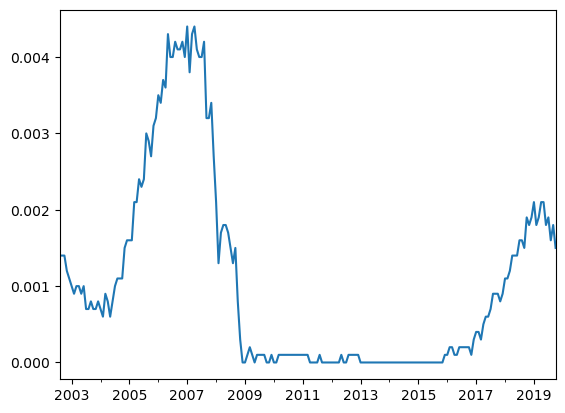

In [24]:
risk_free_rate.plot()

In [26]:
IVV_IEF_daily_ret = pd.read_csv('../../data/IVV_IEF_daily_ret.csv', index_col=0, parse_dates=True)
# get monthly data 
IVV_IEF_monthly_ret = IVV_IEF_daily_ret.groupby(pd.Grouper(freq='M')).apply(get_period_return)
IVV_IEF_monthly_ret.index = [get_monthly_date_format(x) for x in IVV_IEF_monthly_ret.index]

<AxesSubplot:>

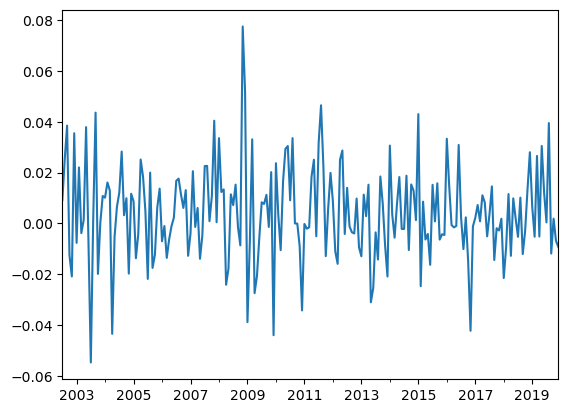

In [28]:
IVV_IEF_monthly_ret['IEF'].plot()

Download ETF data as panel data

In [3]:
df = YahooDownloader(start_date = TRAIN_START_DATE, end_date = TEST_END_DATE, ticker_list = TICKER_LIST).fetch_data()
df.sort_values(['date','tic'],ignore_index=True).head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8686, 8)


,date,open,high,low,close,volume,tic,day
0,2002-08-01,82.540001,82.900002,82.519997,46.281384,71400,IEF,3
1,2002-08-01,91.099998,91.230003,88.449997,59.666138,200300,IVV,3
2,2002-08-02,83.019997,83.699997,82.900002,46.638836,120300,IEF,4
3,2002-08-02,88.699997,88.849998,85.720001,58.344711,314600,IVV,4
4,2002-08-05,83.680000,83.919998,83.529999,46.873421,159300,IEF,0


Clean ETF data

In [4]:
fe = FeatureEngineer(use_technical_indicator=False)
processed = fe.preprocess_data(df)
processed.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2002-08-01,82.540001,82.900002,82.519997,46.281384,71400,IEF,3
1,2002-08-01,91.099998,91.230003,88.449997,59.666138,200300,IVV,3
2,2002-08-02,83.019997,83.699997,82.900002,46.638836,120300,IEF,4
3,2002-08-02,88.699997,88.849998,85.720001,58.344711,314600,IVV,4
4,2002-08-05,83.680000,83.919998,83.529999,46.873421,159300,IEF,0


Import economic data as indicators

In [14]:
macro_features = get_econ_predictors(START_DATE=TRAIN_START_DATE, END_DATE=TRAIN_END_DATE)
macro_features.index.name = 'date'
macro_features.head()

,Equity Premium,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,Term Spread,Default Yield Spread,Default Return Spread,Inflation
date,,,,,,,,,,,,,,,
2002-09,-0.111413,-3.943597,-4.060146,-3.301014,-0.642583,0.007366,0.324555,0.029299,0.0163,0.0480,0.0417,0.0317,0.0125,-0.0087,0.001660
2002-10,0.085036,-4.020712,-3.937810,-3.411480,-0.609232,0.011590,0.293437,0.025671,0.0158,0.0508,-0.0294,0.0350,0.0141,0.0054,0.001657
2002-11,0.055870,-4.070465,-4.014964,-3.495322,-0.575143,0.004449,0.276975,0.022908,0.0123,0.0521,-0.0122,0.0398,0.0131,0.0252,0.000000
2002-12,-0.061433,-4.002514,-4.064744,-3.462264,-0.540250,0.002640,0.295386,0.025736,0.0119,0.0484,0.0507,0.0365,0.0124,-0.0146,-0.002206
2003-01,-0.028415,-3.971611,-3.999408,-3.402016,-0.569595,0.005168,0.305942,0.028289,0.0117,0.0495,-0.0106,0.0378,0.0118,0.0127,0.004422


ETF data LEFT JOIN with the economic indicators

In [18]:
processed

,date,open,high,low,close,volume,tic,day
0,2002-08-01,82.540001,82.900002,82.519997,46.281364,71400,IEF,3
0,2002-08-01,91.099998,91.230003,88.449997,59.666145,200300,IVV,3
1,2002-08-02,83.019997,83.699997,82.900002,46.638832,120300,IEF,4
1,2002-08-02,88.699997,88.849998,85.720001,58.344730,314600,IVV,4
2,2002-08-05,83.680000,83.919998,83.529999,46.873413,159300,IEF,0
...,...,...,...,...,...,...,...,...
4340,2019-10-28,304.549988,305.559998,304.549988,288.733887,4818200,IVV,0
4341,2019-10-29,111.300003,111.349998,111.150002,106.689301,2199500,IEF,1
4341,2019-10-29,304.730011,305.940002,304.559998,288.639191,3443100,IVV,1
4342,2019-10-30,111.349998,111.809998,111.309998,107.207108,5276700,IEF,2


In [17]:
pd.concat([processed, macro_features], axis=1).head()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
# re-arrange the dataframe
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

Data split

In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
test = data_split(processed_full, TEST_START_DATE,TEST_END_DATE)
print(len(train))
print(len(test))

176
20


In [ ]:
INDICATORS = macro_features.columns[1:]
STOCK_DIMENSION = len(train.tic.unique())
STATE_SPACE = 1 + 2*STOCK_DIMENSION + len(INDICATORS) * 2
print(f"Stock Dimension: {STOCK_DIMENSION}, State Space: {STATE_SPACE}")

Stock Dimension: 2, State Space: 33


## Data preparation function
Wrap up everything into a function

In [ ]:
def feature_engineering(TRAIN_START_DATE:str = '2009-01-01',
                        TRAIN_END_DATE:str = '2020-07-01',
                        TEST_START_DATE:str = '2020-07-01',
                        TEST_END_DATE:str = '2021-10-31',
                        TICKER_LIST:list[str] = ['IVV', 'IEF'],
                        user_defined_features_df:pd.DataFrame = None
                        ) -> pd.DataFrame|pd.DataFrame|dict:

    """
    This is the main function for feature engineering.

    Args:
    TRAIN_START_DATE (str, optional): start date of training
    TRAIN_END_DATE (str, optional): end date of training
    TEST_START_DATE (str, optional): start date of testing
    TEST_END_DATE (str, optional): end date of testing
    TICKER_LIST (list[str], optional): list of ticker symbols
    user_defined_features_df (pd.DataFrame, optional): dataframe with user defined features
    """
    equity_df = YahooDownloader(start_date = TRAIN_START_DATE, end_date = TEST_END_DATE, ticker_list = TICKER_LIST).fetch_data()
    fe = FeatureEngineer(use_technical_indicator=False)
    equity_df = fe.preprocess_data(equity_df)
    feature_df = equity_df.merge(user_defined_features_df, on='date', how='left').dropna()

    # re-arrange the dataframe
    list_ticker = feature_df["tic"].unique().tolist()
    list_date = list(pd.date_range(feature_df['date'].min(),feature_df['date'].max()).astype(str))
    combination = list(itertools.product(list_date,list_ticker))
    feature_df_full = pd.DataFrame(combination,columns=["date","tic"]).merge(feature_df,on=["date","tic"],how="left")
    feature_df_full = feature_df_full[feature_df_full['date'].isin(feature_df['date'])]
    feature_df_full = feature_df_full.sort_values(['date','tic'])
    feature_df_full = feature_df_full.fillna(0)

    train = data_split(feature_df_full, TRAIN_START_DATE,TRAIN_END_DATE)
    test = data_split(feature_df_full, TEST_START_DATE,TEST_END_DATE)

    INDICATORS = user_defined_features_df.columns[1:]
    STOCK_DIMENSION = len(train.tic.unique())
    STATE_SPACE = 1 + 2 * STOCK_DIMENSION + len(INDICATORS) * 2

    info_dict = {'indicator_list': INDICATORS,
                 'stock_dimension': STOCK_DIMENSION,
                 'state_space': STATE_SPACE
                }
    
    return train, test, info_dict

test

In [ ]:
macro_features = pd.read_csv('../../data/econ_predictor.csv')
macro_features.rename(columns={'Unnamed: 0':'date'}, inplace=True)
macro_features

,date,CI,IP,CRP,STS,CP,HS,LOAN,DL,NONS,NAPM,UR,MOM,BDC,EVUSD
0,1993-07-01,-0.282172,0.002412,0.76,2.70,174.0556,1254.0,-20.0,-0.45,38915.0,245765.0,-0.1,-0.001849,-0.090971,0.018801
1,1993-08-01,-0.282172,-0.000932,0.75,2.59,175.8414,1300.0,-20.0,-0.45,39309.0,246562.0,-0.1,0.453000,0.070948,-0.014889
2,1993-09-01,0.966665,0.005117,0.68,2.35,177.3570,1343.0,-20.0,-0.45,39307.0,245731.0,-0.1,0.361550,-0.013250,-0.012028
3,1993-10-01,-0.864620,0.007432,0.64,2.24,171.4164,1392.0,-18.6,-0.09,40550.0,251656.0,0.1,0.322654,-0.069258,0.024348
4,1993-11-01,-1.031200,0.004756,0.73,2.54,165.0651,1376.0,-18.6,-0.09,40301.0,247827.0,-0.2,-0.029824,-0.048595,0.011885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2021-05-01,0.158655,0.007613,0.66,1.60,519.2278,1605.0,-32.4,-0.04,66882.0,476677.0,-0.2,3.013197,-0.149689,-0.015896
335,2021-06-01,-0.482720,0.004147,0.65,1.48,535.9755,1664.0,-32.4,-0.04,68158.0,486157.0,0.1,7.445016,0.303159,0.029022
336,2021-07-01,0.314160,0.006788,0.67,1.27,541.1290,1573.0,-18.2,0.03,68660.0,487733.0,-0.5,12.742203,-0.026899,-0.002834
337,2021-08-01,0.314160,-0.000351,0.69,1.23,527.3677,1576.0,-18.2,0.03,69530.0,493380.0,-0.2,9.293577,0.255164,0.004904


In [ ]:
train, test, info_dict = feature_engineering(user_defined_features_df = macro_features)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (6460, 8)


Hyper-parameters

In [ ]:
INDICATORS = info_dict['indicator_list']
STOCK_DIMENSION = info_dict['stock_dimension']
STATE_SPACE = info_dict['state_space']
BUY_COST_LIST = SELL_COST_LIST = [0.000] * STOCK_DIMENSION
NUM_STOCK_SHARES = [0] * STOCK_DIMENSION

In [ ]:
env_kwargs = {
    "hmax": 1000,
    "initial_amount": 1000000,
    "num_stock_shares": NUM_STOCK_SHARES,
    "buy_cost_pct": BUY_COST_LIST,
    "sell_cost_pct": SELL_COST_LIST,
    "state_space": STATE_SPACE,
    "stock_dim": STOCK_DIMENSION,
    "tech_indicator_list": INDICATORS,
    "action_space": STOCK_DIMENSION,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


In [ ]:
env_train, _ = e_train_gym.get_sb_env()

In [ ]:
agent = DRLAgent(env = env_train)

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = '../../log/' + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])

# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to ../../log//ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=500000)

day: 87, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1260569.68
total_reward: 260569.68
total_cost: 0.00
total_trades: 155
Sharpe: 1.559
day: 87, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1422254.86
total_reward: 422254.86
total_cost: 0.00
total_trades: 160
Sharpe: 6.564
------------------------------------
| time/              |             |
|    fps             | 887         |
|    iterations      | 1           |
|    time_elapsed    | 2           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.39894804 |
------------------------------------
day: 87, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1690655.92
total_reward: 690655.92
total_cost: 0.00
total_trades: 161
Sharpe: 3.448
day: 87, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 1942039.38
total_reward: 942039.38
total_cost: 0.00
total_trades: 162
Sharpe: 5.266
-----------------------------------------
| time/          